In [1]:
import json
import numpy as np
import pandas as pd
import os
# Used to randomly shuffle the data
import random
# Used to copy/move from data source to data destination
import shutil
# Used to get the image data
import base64

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Open the JSON file
with open('/content/drive/MyDrive/AA USD/AAI 521 Computer Vision/Project/fashionpedia_validation_annotation.json') as f:
    data = json.load(f)

# /content/drive/MyDrive/AA USD/AAI 521 Computer Vision/Project/fashionpedia_validation_annotation.json

In [4]:
# List the parent nodes
parent_nodes = list(data.keys())
print(parent_nodes)

['info', 'categories', 'attributes', 'licenses', 'annotations', 'images']


In [5]:
# Assuming 'data' is your loaded JSON data
dataframes = {}

In [6]:
for key in data.keys():
    # Check if the data under the key is a list
    if isinstance(data[key], list):
        # Convert the dataset to a pandas DataFrame
        dataframes[key] = pd.DataFrame(data[key])
    elif isinstance(data[key], dict):
        # If the data is a dictionary of scalar values, convert it to a DataFrame with a single row
        dataframes[key] = pd.DataFrame([data[key]])
    else:
        # If the data is a scalar value, convert it to a DataFrame with a single row
        dataframes[key] = pd.DataFrame([data[key]])

In [7]:
# Now you can access each dataframe using its parent node name
# For example, to access the dataframe under the parent node 'node1', you can use:
df_cat = dataframes['categories']
df_att = dataframes['attributes']
df_ann = dataframes['annotations']
df_images = dataframes['images']

In [8]:
# Review the catagories to determine which ones to be used to custom train the model
df_cat

,id,name,supercategory,level,taxonomy_id
0,0,"shirt, blouse",upperbody,2,combo000000
1,1,"top, t-shirt, sweatshirt",upperbody,2,combo000001
2,2,sweater,upperbody,2,obj000008_00
3,3,cardigan,upperbody,2,obj000009_00
4,4,jacket,upperbody,2,obj000010_00
5,5,vest,upperbody,2,obj000011_00
6,6,pants,lowerbody,2,obj000013_00
7,7,shorts,lowerbody,2,obj000014_00
8,8,skirt,lowerbody,2,obj000015_00
9,9,coat,wholebody,2,obj000017_00


In [11]:
# Join the dataframes on 'image_id' and 'id'
df_ann_images = pd.merge(df_ann, df_images, left_on='image_id', right_on='id')

# Join the dataframes on 'category_id' and 'id'
df_cat_ann_images = pd.merge(df_ann_images, df_cat, left_on='category_id', right_on='id')

In [16]:
df_ann.value_counts('category_id')

category_id
23    1566
31    1442
33     929
32     541
10     508
1      477
6      314
28     218
24     214
35     194
4      183
19     164
8      162
42     143
29     135
13     130
21     122
15     109
37     107
7      106
9      104
0      102
22      87
18      84
43      76
14      74
34      67
36      61
25      48
45      39
39      37
27      32
17      31
40      30
5       22
11      21
2       21
30      14
20      14
44      13
3       12
41       9
38       6
26       5
12       5
16       3
dtype: int64

In [12]:
# Initialize an empty dataframe to store the results
df_results = pd.DataFrame()

In [13]:
# Iterating through catagories 1-11 and include 14 and 24
for i in list(range(12))+ [14, 24]:
    # Get the records associated with the current category_id
    df_temp = df_cat_ann_images[df_cat_ann_images['category_id'] == i]
    # Append the records to the results dataframe
    df_results = pd.concat([df_results, df_temp])

In [13]:
# Filter df_results to include only rows where 'segmentation' values start with '[['
# Based on the documentation, this indicates a polygon data structure
df_results = df_results[df_results['segmentation'].astype(str).str.startswith('[[')]

In [14]:
df_results

,image_id,category_id,attribute_ids,segmentation,bbox,area,iscrowd,id_x,id_y,width,...,license,time_captured,original_url,isstatic,kaggle_id,id,name,supercategory,level,taxonomy_id
6069,15069,0,"[316, 295, 136, 225, 147, 115, 145, 321]","[[245, 414, 256, 362, 253, 325, 251, 299, 238,...","[97, 162, 336, 400]",52694,0,40,15069,632,...,4,"March-August, 2018",https://www.flickr.com/photos/westerncanadafas...,0,d67ad10df9224b51361c9dfb18f5a9ef,0,"shirt, blouse",upperbody,2,combo000000
6070,15106,0,"[317, 142, 295, 136, 225, 115]","[[512, 182, 517, 184, 520, 186, 524, 187, 530,...","[478, 163, 99, 239]",11479,0,80,15106,1024,...,3,"March-August, 2018",http://farm2.staticflickr.com/1572/24025260386...,1,790cc5b2e3f130e9f45cde050b74c055,0,"shirt, blouse",upperbody,2,combo000000
6071,15229,0,"[325, 225]","[[322, 184, 327, 205, 332, 219, 339, 227, 345,...","[315, 172, 70, 127]",2161,0,178,15229,683,...,4,"March-August, 2018",https://www.flickr.com/photos/westerncanadafas...,0,330629f6ea12a084fa484a2ae181d1ab,0,"shirt, blouse",upperbody,2,combo000000
6072,15255,0,"[316, 295, 136, 225, 319, 115]","[[307, 634, 310, 636, 316, 643, 324, 654, 314,...","[190, 368, 147, 314]",11613,0,191,15255,682,...,4,"March-August, 2018",http://farm6.staticflickr.com/5490/12513783364...,1,035b280e6bfd861226dbd2d1c8f89873,0,"shirt, blouse",upperbody,2,combo000000
6073,15515,0,"[316, 317, 295, 136, 225, 115]","[[553, 264, 557, 274, 564, 232, 566, 226, 575,...","[453, 198, 260, 298]",6517,0,386,15515,1024,...,3,"March-August, 2018",http://farm2.staticflickr.com/1569/24335509776...,1,72a138c47a27759553ebb2b2c1a94707,0,"shirt, blouse",upperbody,2,combo000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,13414,24,[],"[[470, 672, 462, 615, 460, 587, 451, 583, 451,...","[410, 549, 62, 131]",5172,0,9107,13414,731,...,5,"March-August, 2018",http://farm4.staticflickr.com/3017/4606911785_...,1,963999a4ce820148817057ade3cc956d,24,"bag, wallet",others,2,combo000004
1834,13445,24,[],"[[244, 439, 240, 444, 235, 448, 233, 456, 228,...","[227, 440, 28, 103]",1459,0,9136,13445,678,...,3,"March-August, 2018",http://farm8.staticflickr.com/7118/7590687856_...,1,bbb7c11a2a4fe731a371cdf9e223c360,24,"bag, wallet",others,2,combo000004
1835,13482,24,[],"[[184, 1004, 164, 1005, 96, 992, 39, 975, 31, ...","[31, 573, 179, 432]",45894,0,9174,13482,682,...,4,"March-August, 2018",http://farm2.staticflickr.com/1088/1450363100_...,1,a13f7be475e3cf371b342c0f2e320836,24,"bag, wallet",others,2,combo000004
1836,13483,24,[],"[[378, 612, 380, 618, 382, 621, 384, 627, 386,...","[373, 538, 88, 134]",5595,0,9185,13483,682,...,4,"March-August, 2018",http://farm2.staticflickr.com/1672/24465864933...,1,05af199570c00b817102c3cb6834a6e4,24,"bag, wallet",others,2,combo000004


In [16]:
df_results.columns

Index(['image_id', 'category_id', 'attribute_ids', 'segmentation', 'bbox',
       'area', 'iscrowd', 'id_x', 'id_y', 'width', 'height', 'file_name',
       'license', 'time_captured', 'original_url', 'isstatic', 'kaggle_id',
       'id', 'name', 'supercategory', 'level', 'taxonomy_id'],
      dtype='object')

In [17]:
df_results.shape

(2316, 22)

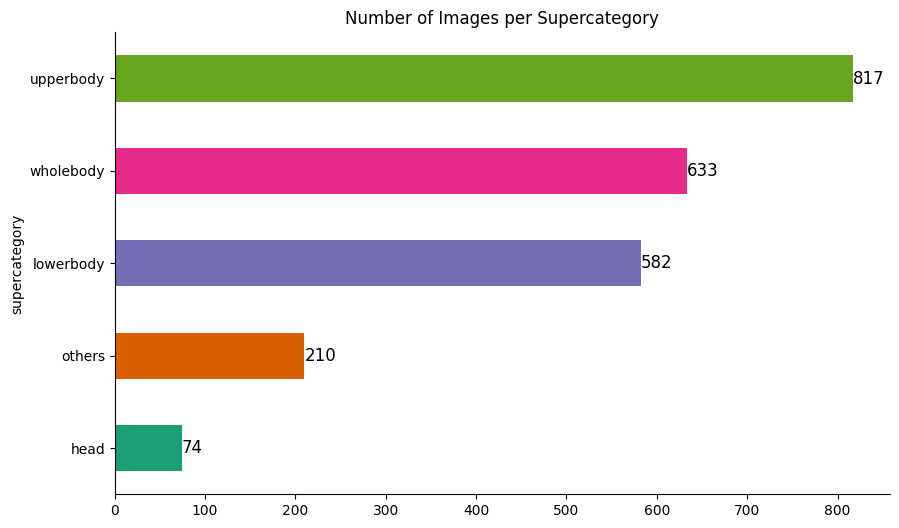

In [ ]:
# Group by 'supercategory', count the occurrences, and sort in ascending order
supercategory_counts = df_results.groupby('supercategory').size().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
bar_plot = supercategory_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Adding a title
plt.title('Number of Images per Supercategory')

# Adding value counts on the chart with larger font size
for p in bar_plot.patches:
    plt.text(p.get_width(), p.get_y() + p.get_height() / 2,
             str(int(p.get_width())), va='center', fontsize=12)  # Adjust fontsize as needed

plt.show()

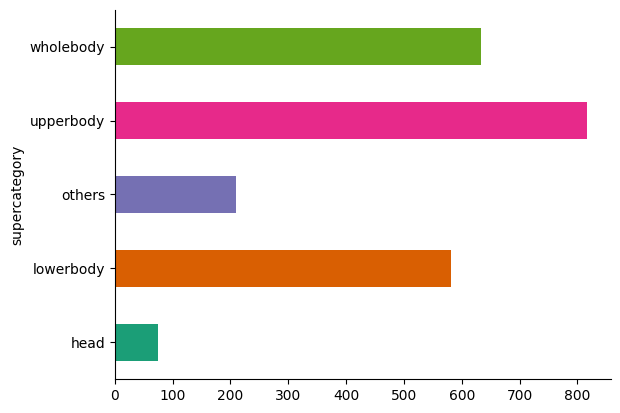

In [ ]:
# # Show number of images per super category
# df_results.groupby('supercategory').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

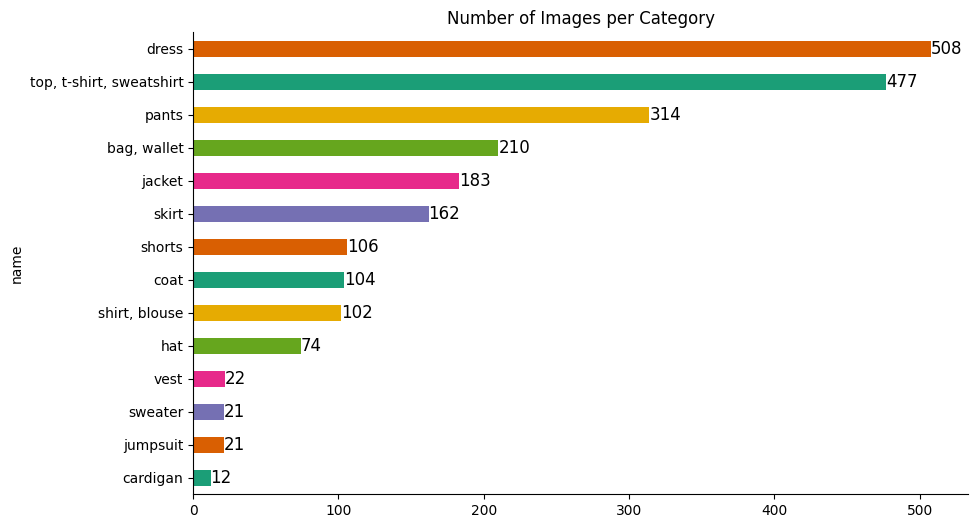

In [ ]:
# Group by 'name', count the occurrences, and sort in descending order
category_counts = df_results.groupby('name').size().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
bar_plot = category_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Adding a title
plt.title('Number of Images per Category')

# Adding value counts on the chart with larger font size
for p in bar_plot.patches:
    plt.text(p.get_width(), p.get_y() + p.get_height() / 2,
             str(int(p.get_width())), va='center', fontsize=12)  # Adjust fontsize as needed

plt.show()

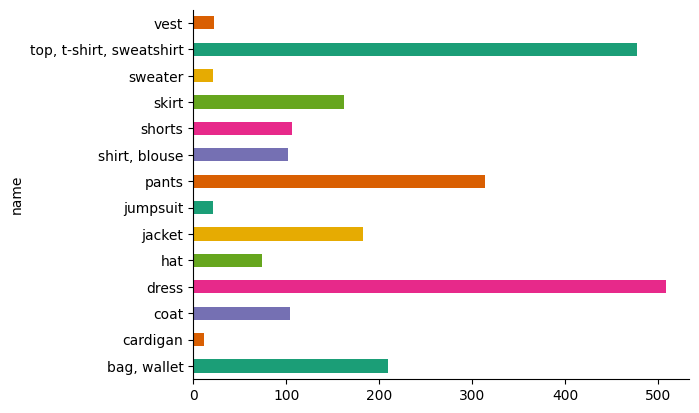

In [ ]:
# Show number of images per category name
df_results.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

###Convert Fashionpedia Dataset Annotation to LabelMe Annotation

In [ ]:
# Path to the Fashionpedia dataset images
fashionpedia_images_dir = '/content/drive/MyDrive/test'

In [ ]:
# Path to the export directory
fashionpedia_images_export_dir = os.path.join(fashionpedia_images_dir, 'exports')

In [ ]:
# Create the export directory if it does not exist
os.makedirs(fashionpedia_images_export_dir, exist_ok=True)

In [ ]:
# Get a list of image names from the df_results dataframe
# In the dataset, the images are listed by kaggle_id
image_names = df_results['file_name'].tolist()

In [ ]:
# Define a function to check if a directory has any images with png or jpg extensions
def has_images(dir_path):
    # Get a list of file names in the directory
    file_names = os.listdir(dir_path)
    # Check if any file name ends with png or jpg
    for file_name in file_names:
        if file_name.lower().endswith(('.png', '.jpg')):
            # Return True if an image is found
            return True
    # Return False if no image is found
    return False

In [ ]:
# Copy the images from the fashionpedia_images_dir to the fashionpedia_images_export_dir
# Only do this if the export directory has no images
if not has_images(fashionpedia_images_export_dir):
    for image_name in image_names:
        # Get the source and destination paths
        src_path = os.path.join(fashionpedia_images_dir, image_name)
        dst_path = os.path.join(fashionpedia_images_export_dir, image_name)
        # Copy the image file
        shutil.copy(src_path, dst_path)

In [ ]:
# Copy the images from the fashionpedia_images_dir to the fashionpedia_images_export_dir
for image_name in image_names:
    # Get the source and destination paths
    src_path = os.path.join(fashionpedia_images_dir, image_name)
    dst_path = os.path.join(fashionpedia_images_export_dir, image_name)
    # Copy the image file
    shutil.copy(src_path, dst_path)

In [ ]:
# Define a custom encoder class that converts int64 to int
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        return super(NpEncoder, self).default(obj)

In [ ]:
# Add Dataframe to use to check which files have the catagories assigned to them
inventory_df_results = pd.DataFrame(columns=['image_name', 'category_name'])

In [ ]:
# Generate the json files for each image
for image_name in image_names:
    # Get the corresponding record from the results dataframe
    record = df_results[df_results['file_name'] == image_name]
    # Get the category name, polygon, bbox, image height and width from the record
    category_name = record['name'].values[0]
    polygon = record['segmentation'].values[0]
    bbox = record['bbox'].values[0]
    image_height = record['height'].values[0]
    image_width = record['width'].values[0]
    # Check if the polygon is a nested list
    if isinstance(polygon[0], list):
      # Remove the outer list by taking the first element
      polygon = polygon[0]
    # Convert the polygon from a single list to a list of pairs
    polygon = [polygon[i:i+2] for i in range(0, len(polygon), 2)]
    # Unpack the values into x1, y1, x2, y2 from the bbox variable
    x1, y1, x2, y2 = bbox
    # Convert the bbox from a single list to a list of pairs
    # Swap the y coordinates to make the top-left corner (x1, y2) and the bottom-right corner (x2, y1)
    bbox = [[x1, y1],[x2, y2],[x1, y2], [x2, y1]]
    # Get the image path
    image_path = os.path.join(fashionpedia_images_export_dir, image_name)
    # Read the image bytes
    with open(image_path, 'rb') as f:
        image_bytes = f.read()
    # Encode the image bytes as a base64 string
    image_data = base64.b64encode(image_bytes).decode()
    # Create a json data structure
    json_data = {
        "version": "5.2.1",
        "flags": {},
        "shapes": [
            {
                "label": category_name,
                "points": polygon,
                "group_id": None,
                "description": None,
                "shape_type": "polygon",
                "flags": {}
            },
            {
                "label": category_name,
                "points": bbox,
                "group_id": None,
                "description": None,
                "shape_type": "rectangle",
                "flags": {}
            }
        ],
        "imagePath": image_name,
        "imageData": image_data,
        "imageHeight": image_height,
        "imageWidth": image_width
    }
    # Get the image name without the extension
    image_name = os.path.splitext(image_name)[0]
    # Get the json file path
    json_path = os.path.join(fashionpedia_images_export_dir, image_name + '.json')
    # Write the json data to the file
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2, cls=NpEncoder)
    # Add a new operation inside the for loop to add the image_name and category_name to the inventory_df_results dataframe
    inventory_df_results = pd.concat([inventory_df_results, pd.DataFrame({'image_name': [image_name], 'category_name': [category_name]})], ignore_index=True)

<ipython-input-26-cce203087b1f>:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inventory_df_results = inventory_df_results.append({'image_name': image_name, 'category_name': category_name}, ignore_index=True)
<ipython-input-26-cce203087b1f>:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inventory_df_results = inventory_df_results.append({'image_name': image_name, 'category_name': category_name}, ignore_index=True)
<ipython-input-26-cce203087b1f>:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inventory_df_results = inventory_df_results.append({'image_name': image_name, 'category_name': category_name}, ignore_index=True)
<ipython-input-26-cce203087b1f>:64: FutureWarning: The frame.append method is deprecated and will

In [ ]:
inventory_df_results

,image_name,category_name
0,d67ad10df9224b51361c9dfb18f5a9ef,"shirt, blouse"
1,790cc5b2e3f130e9f45cde050b74c055,"shirt, blouse"
2,330629f6ea12a084fa484a2ae181d1ab,"shirt, blouse"
3,035b280e6bfd861226dbd2d1c8f89873,"shirt, blouse"
4,72a138c47a27759553ebb2b2c1a94707,"shirt, blouse"
...,...,...
2311,963999a4ce820148817057ade3cc956d,"top, t-shirt, sweatshirt"
2312,bbb7c11a2a4fe731a371cdf9e223c360,jacket
2313,a13f7be475e3cf371b342c0f2e320836,dress
2314,05af199570c00b817102c3cb6834a6e4,sweater


No charts were generated by quickchart


In [ ]:
# Path to the exports folder
exports_dir = '/content/drive/MyDrive/test/exports'

In [ ]:
# Initialize the counters for JSON and jpg files
json_count = 0
jpg_count = 0

# Iterate through the files in the exports folder
for file_name in os.listdir(exports_dir):
    # Check if the file name ends with .json or .jpg
    if file_name.lower().endswith('.json'):
        # Increment the JSON counter
        json_count += 1
    elif file_name.lower().endswith('.jpg'):
        # Increment the jpg counter
        jpg_count += 1

# Print the counts
print(f'There are {json_count} JSON files and {jpg_count} jpg files in the exports folder.')


There are 1158 JSON files and 1158 jpg files in the exports folder.


In [ ]:
# Path to the train folder
train_dir = os.path.join(exports_dir, 'train')
# Create the train folder if it does not exist
os.makedirs(train_dir, exist_ok=True)

# Path to the test folder
test_dir = os.path.join(exports_dir, 'test')
# Create the test folder if it does not exist
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Get a list of JSON file names in the exports folder
json_files = [file_name for file_name in os.listdir(exports_dir) if file_name.lower().endswith('.json')]

# Shuffle the list of JSON file names
random.shuffle(json_files)

# Calculate the number of files for the test set (30% of the total)
test_size = int(len(json_files) * 0.3)

# Split the list of JSON file names into train and test sets
train_files = json_files[test_size:]
test_files = json_files[:test_size]

In [ ]:
# Create an empty dictionary to store the category counts for the train set
train_category_counts = {}

In [ ]:
# Loop through the train files
for file_name in train_files:
    # Get the image name without the extension
    image_name = os.path.splitext(file_name)[0]
    # Get the category name from the inventory_df_results dataframe
    category_name = inventory_df_results[inventory_df_results['image_name'] == image_name]['category_name'].values[0]
    # Increment the category count by one or initialize it to one if it does not exist
    train_category_counts[category_name] = train_category_counts.get(category_name, 0) + 1

In [ ]:
print(train_category_counts)

{'top, t-shirt, sweatshirt': 300, 'dress': 317, 'jacket': 36, 'shirt, blouse': 75, 'coat': 17, 'sweater': 11, 'vest': 6, 'skirt': 5, 'pants': 27, 'jumpsuit': 9, 'shorts': 4, 'cardigan': 4}


In [ ]:
# Create an empty dictionary to store the category counts for the test set
test_category_counts = {}

In [ ]:
# Loop through the test files
for file_name in test_files:
    # Get the image name without the extension
    image_name = os.path.splitext(file_name)[0]
    # Get the category name from the inventory_df_results dataframe
    category_name = inventory_df_results[inventory_df_results['image_name'] == image_name]['category_name'].values[0]
    # Increment the category count by one or initialize it to one if it does not exist
    test_category_counts[category_name] = test_category_counts.get(category_name, 0) + 1

In [ ]:
print(test_category_counts)

{'top, t-shirt, sweatshirt': 145, 'dress': 111, 'jacket': 29, 'shirt, blouse': 27, 'coat': 16, 'jumpsuit': 6, 'pants': 6, 'sweater': 6, 'vest': 1}


In [ ]:
# Loop through the categories in the train set
for category in train_category_counts:
    # Get the count of the category in the train set
    train_count = train_category_counts[category]
    # Get the count of the category in the test set
    test_count = test_category_counts.get(category, 0)
    # Check if the test count is less than the train count
    if test_count < train_count:
        # Calculate the difference
        diff = train_count - test_count
        # Get a list of file names in the train set that belong to the category
        train_files_category = [file_name for file_name in train_files if inventory_df_results[inventory_df_results['image_name'] == os.path.splitext(file_name)[0]]['category_name'].values[0] == category]
        # Shuffle the list of file names
        random.shuffle(train_files_category)
        # Take the first diff number of file names
        train_files_to_move = train_files_category[:diff]
        # Move the files from the train set to the test set
        for file_name in train_files_to_move:
            # Remove the file name from the train_files list
            train_files.remove(file_name)
            # Add the file name to the test_files list
            test_files.append(file_name)
            # Decrement the train count by one
            train_category_counts[category] -= 1
            # Increment the test count by one
            test_category_counts[category] = test_category_counts.get(category, 0) + 1

In [ ]:
print(test_category_counts)

{'top, t-shirt, sweatshirt': 145, 'dress': 111, 'jacket': 29, 'shirt, blouse': 27, 'coat': 16, 'jumpsuit': 6, 'pants': 6, 'sweater': 6, 'vest': 1, 'skirt': 0, 'shorts': 0, 'cardigan': 0}


In [ ]:
# Loop through the categories in the test set
for category in test_category_counts:
    # Get the count of the category in the test set
    test_count = test_category_counts[category]
    # Get the count of the category in the train set
    train_count = train_category_counts.get(category, 0)
    # Check if the train count is less than the test count
    if train_count < test_count:
        # Calculate the difference
        diff = test_count - train_count
        # Get a list of file names in the test set that belong to the category
        test_files_category = [file_name for file_name in test_files if inventory_df_results[inventory_df_results['image_name'] == os.path.splitext(file_name)[0]]['category_name'].values[0] == category]
        # Shuffle the list of file names
        random.shuffle(test_files_category)
        # Take the first diff number of file names
        test_files_to_move = test_files_category[:diff]
        # Move the files from the test set to the train set
        for file_name in test_files_to_move:
            # Remove the file name from the test_files list
            test_files.remove(file_name)
            # Add the file name to the train_files list
            train_files.append(file_name)
            # Decrement the test count by one
            test_category_counts[category] -= 1
            # Increment the train count by one
            train_category_counts[category] = train_category_counts.get(category, 0) + 1

In [ ]:
print(train_category_counts)

{'top, t-shirt, sweatshirt': 300, 'dress': 317, 'jacket': 36, 'shirt, blouse': 75, 'coat': 17, 'sweater': 11, 'vest': 6, 'skirt': 5, 'pants': 27, 'jumpsuit': 9, 'shorts': 4, 'cardigan': 4}


In [ ]:
# Move the JSON files and the corresponding jpeg files to the train folder
for file_name in train_files:
    # Get the source and destination paths for the JSON file
    src_path = os.path.join(exports_dir, file_name)
    dst_path = os.path.join(train_dir, file_name)
    # Move the JSON file
    shutil.move(src_path, dst_path)
    # Get the source and destination paths for the jpeg file
    # Replace the .json extension with .jpg
    src_path = os.path.join(exports_dir, file_name.replace('.json', '.jpg'))
    dst_path = os.path.join(train_dir, file_name.replace('.json', '.jpg'))
    # Move the jpeg file
    shutil.move(src_path, dst_path)


In [ ]:
# Move the JSON files and the corresponding jpeg files to the test folder
for file_name in test_files:
    # Get the source and destination paths for the JSON file
    src_path = os.path.join(exports_dir, file_name)
    dst_path = os.path.join(test_dir, file_name)
    # Move the JSON file
    shutil.move(src_path, dst_path)
    # Get the source and destination paths for the jpeg file
    # Replace the .json extension with .jpg
    src_path = os.path.join(exports_dir, file_name.replace('.json', '.jpg'))
    dst_path = os.path.join(test_dir, file_name.replace('.json', '.jpg'))
    # Move the jpeg file
    shutil.move(src_path, dst_path)
